In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set matplotlib style
sns.set_context("talk", font_scale=.8)

---

In [3]:
# Read the basin metrics files
challenger_metrics = pd.read_csv("/Users/cooper/Desktop/CAMELS-CH/experiments/Exp3/results/challenger_basin_metrics.csv")
benchmark_metrics = pd.read_csv("/Users/cooper/Desktop/CAMELS-CH/experiments/Exp3/results/basin_metrics.csv")

In [4]:
# Process the data
def calculate_performance_comparison(challenger_df, benchmark_df):
    # Reset index to make sure we can access basin_id and horizon directly
    challenger_df = challenger_df.reset_index()
    benchmark_df = benchmark_df.reset_index()

    # Get unique horizons
    horizons = sorted(challenger_df["horizon"].unique())

    # Initialize results dictionary
    results = {
        "horizon": [],
        "better": [],  # Percentage where challenger significantly outperforms (>=0.05)
        "insignificant": [],  # Percentage where change is insignificant (<0.05)
        "worse": [],  # Percentage where benchmark significantly outperforms (<=-0.05)
    }

    # For each horizon, compare NSE scores
    for horizon in horizons:
        challenger_horizon = challenger_df[challenger_df["horizon"] == horizon]
        benchmark_horizon = benchmark_df[benchmark_df["horizon"] == horizon]

        # Merge the data for this horizon
        comparison = pd.merge(
            challenger_horizon,
            benchmark_horizon,
            on=["basin_id", "horizon"],
            suffixes=("_challenger", "_benchmark"),
        )

        # Calculate total number of basins for this horizon
        total_basins = len(comparison)

        # Compute difference between challenger and benchmark
        diff = comparison["NSE_challenger"] - comparison["NSE_benchmark"]

        # Count significant differences based on threshold 0.05
        challenger_wins = (diff >= 0.05).sum()
        benchmark_wins = (diff <= -0.05).sum()
        insignificant = (abs(diff) < 0.05).sum()

        # Calculate percentages
        pct_better = (challenger_wins / total_basins) * 100
        pct_insig = (insignificant / total_basins) * 100
        pct_worse = (benchmark_wins / total_basins) * 100

        # Store results
        results["horizon"].append(horizon)
        results["better"].append(pct_better)
        results["insignificant"].append(pct_insig)
        results["worse"].append(pct_worse)

    return pd.DataFrame(results)

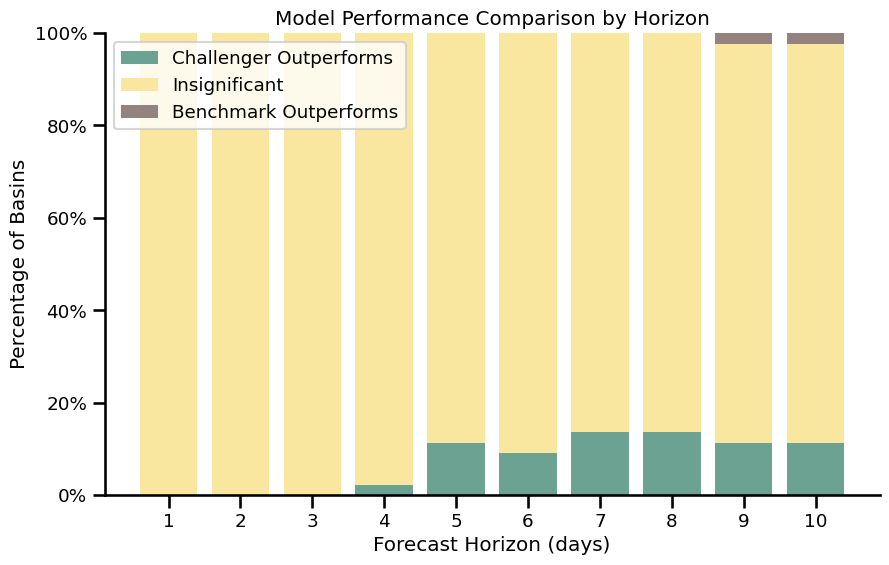

In [5]:
# Calculate performance comparison
comparison_df = calculate_performance_comparison(challenger_metrics, benchmark_metrics)

pastel_green = "#6BA292"  # Pale green
pastel_red = "#93827F"  # Light pink
pastel_yellow = "#F9E79F"  # Yellowish for insignificant differences

# Create the visualization
plt.figure(figsize=(10, 6))

plt.bar(
    comparison_df["horizon"],
    comparison_df["better"],
    label="Challenger Outperforms",
    color=pastel_green,
)
plt.bar(
    comparison_df["horizon"],
    comparison_df["insignificant"],
    bottom=comparison_df["better"],
    label="Insignificant",
    color=pastel_yellow,
)
plt.bar(
    comparison_df["horizon"],
    comparison_df["worse"],
    bottom=comparison_df["better"] + comparison_df["insignificant"],
    label="Benchmark Outperforms",
    color=pastel_red,
)

plt.xlabel("Forecast Horizon (days)")
plt.ylabel("Percentage of Basins")
plt.title("Model Performance Comparison by Horizon")
plt.legend()
plt.ylim(0, 100)

sns.despine()
plt.yticks(np.arange(0, 101, 20), [f"{i}%" for i in range(0, 101, 20)])
plt.xticks(np.arange(comparison_df["horizon"].min(), comparison_df["horizon"].max() + 1, 1))

plt.show()

In [6]:
print("\nPerformance Summary:")
print(
    f"Average percentage where challenger outperforms: {comparison_df['better'].mean():.1f}%"
)
print(
    f"Best horizon for challenger: {comparison_df.loc[comparison_df['better'].idxmax(), 'horizon']} "
    f"({comparison_df['better'].max():.1f}%)"
)
print(
    f"Worst horizon for challenger: {comparison_df.loc[comparison_df['better'].idxmin(), 'horizon']} "
    f"({comparison_df['better'].min():.1f}%)"
)


Performance Summary:
Average percentage where challenger outperforms: 7.3%
Best horizon for challenger: 7 (13.6%)
Worst horizon for challenger: 1 (0.0%)


In [7]:
def analyze_basin_performance(challenger_df, benchmark_df):
    # Reset index to make sure we can access basin_id and horizon directly
    challenger_df = challenger_df.reset_index()
    benchmark_df = benchmark_df.reset_index()

    # Get unique horizons
    horizons = sorted(challenger_df["horizon"].unique())

    # Initialize dictionaries to store results
    consistently_better_basins = (
        set()
    )  # Basins where challenger wins across ALL horizons
    consistently_worse_basins = (
        set()
    )  # Basins where challenger loses across ALL horizons
    mixed_performance_basins = set()  # Basins with mixed results

    # Dictionary to store performance by horizon
    horizon_results = {}

    # Analyze each horizon
    for horizon in horizons:
        challenger_horizon = challenger_df[challenger_df["horizon"] == horizon]
        benchmark_horizon = benchmark_df[benchmark_df["horizon"] == horizon]

        # Merge the data for this horizon
        comparison = pd.merge(
            challenger_horizon,
            benchmark_horizon,
            on=["basin_id", "horizon"],
            suffixes=("_challenger", "_benchmark"),
        )

        # Calculate performance difference
        comparison["improvement"] = (
            comparison["NSE_challenger"] - comparison["NSE_benchmark"]
        )

        # Get better and worse basins for this horizon
        better_basins = set(comparison[comparison["improvement"] > 0]["basin_id"])
        worse_basins = set(comparison[comparison["improvement"] <= 0]["basin_id"])

        # Store results for this horizon
        horizon_results[horizon] = {
            "better_basins": better_basins,
            "worse_basins": worse_basins,
            "mean_improvement": comparison["improvement"].mean(),
            "comparison_data": comparison,
        }

        # Update consistent performance sets
        if horizon == horizons[0]:
            consistently_better_basins = better_basins
            consistently_worse_basins = worse_basins
        else:
            consistently_better_basins &= better_basins
            consistently_worse_basins &= worse_basins

    # Identify basins with mixed performance
    all_basins = set(challenger_df["basin_id"].unique())
    mixed_performance_basins = (
        all_basins - consistently_better_basins - consistently_worse_basins
    )

    return {
        "consistently_better": consistently_better_basins,
        "consistently_worse": consistently_worse_basins,
        "mixed_performance": mixed_performance_basins,
        "horizon_results": horizon_results,
    }


# Run the analysis
results = analyze_basin_performance(challenger_metrics, benchmark_metrics)

# Print summary
print("\nPerformance Analysis Summary:")
print(f"\nConsistently Better Basins ({len(results['consistently_better'])} basins):")
print(sorted(results["consistently_better"]))

print(f"\nConsistently Worse Basins ({len(results['consistently_worse'])} basins):")
print(sorted(results["consistently_worse"]))

print(f"\nMixed Performance Basins ({len(results['mixed_performance'])} basins):")
print(sorted(results["mixed_performance"]))

# Detailed horizon analysis
print("\nHorizon-by-Horizon Analysis:")
for horizon, data in results["horizon_results"].items():
    better_count = len(data["better_basins"])
    worse_count = len(data["worse_basins"])
    total = better_count + worse_count
    print(f"\nHorizon {horizon}:")
    print(f"Better: {better_count} basins ({better_count/total*100:.1f}%)")
    print(f"Worse: {worse_count} basins ({worse_count/total*100:.1f}%)")
    print(f"Mean NSE improvement: {data['mean_improvement']:.3f}")

# Save detailed results to CSV
print("\nSaving detailed basin classifications...")
basin_classifications = pd.DataFrame(
    {
        "basin_id": sorted(
            list(
                results["consistently_better"]
                | results["consistently_worse"]
                | results["mixed_performance"]
            )
        ),
        "performance": [
            (
                "consistently_better"
                if basin in results["consistently_better"]
                else (
                    "consistently_worse"
                    if basin in results["consistently_worse"]
                    else "mixed"
                )
            )
            for basin in sorted(
                list(
                    results["consistently_better"]
                    | results["consistently_worse"]
                    | results["mixed_performance"]
                )
            )
        ],
    }
)

print("Results saved to 'basin_classifications.csv'")


Performance Analysis Summary:

Consistently Better Basins (4 basins):
['CA_15039', 'CA_16134', 'CA_17338', 'CA_17462']

Consistently Worse Basins (3 basins):
['CA_15069', 'CA_16153', 'CA_17100']

Mixed Performance Basins (37 basins):
['CA_15013', 'CA_15020', 'CA_15022', 'CA_15025', 'CA_15040', 'CA_15044', 'CA_15045', 'CA_15070', 'CA_15081', 'CA_15083', 'CA_15090', 'CA_15194', 'CA_15214', 'CA_15216', 'CA_15259', 'CA_15283', 'CA_15285', 'CA_15287', 'CA_16055', 'CA_16068', 'CA_16070', 'CA_16101', 'CA_16105', 'CA_16135', 'CA_16136', 'CA_16151', 'CA_16158', 'CA_16159', 'CA_16160', 'CA_16161', 'CA_16176', 'CA_17050', 'CA_17077', 'CA_17137', 'CA_17150', 'CA_17288', 'CA_17325']

Horizon-by-Horizon Analysis:

Horizon 1:
Better: 4 basins (57.1%)
Worse: 3 basins (42.9%)
Mean NSE improvement: -0.005

Horizon 2:
Better: 22 basins (50.0%)
Worse: 22 basins (50.0%)
Mean NSE improvement: -0.000

Horizon 3:
Better: 33 basins (75.0%)
Worse: 11 basins (25.0%)
Mean NSE improvement: 0.007

Horizon 4:
Bette

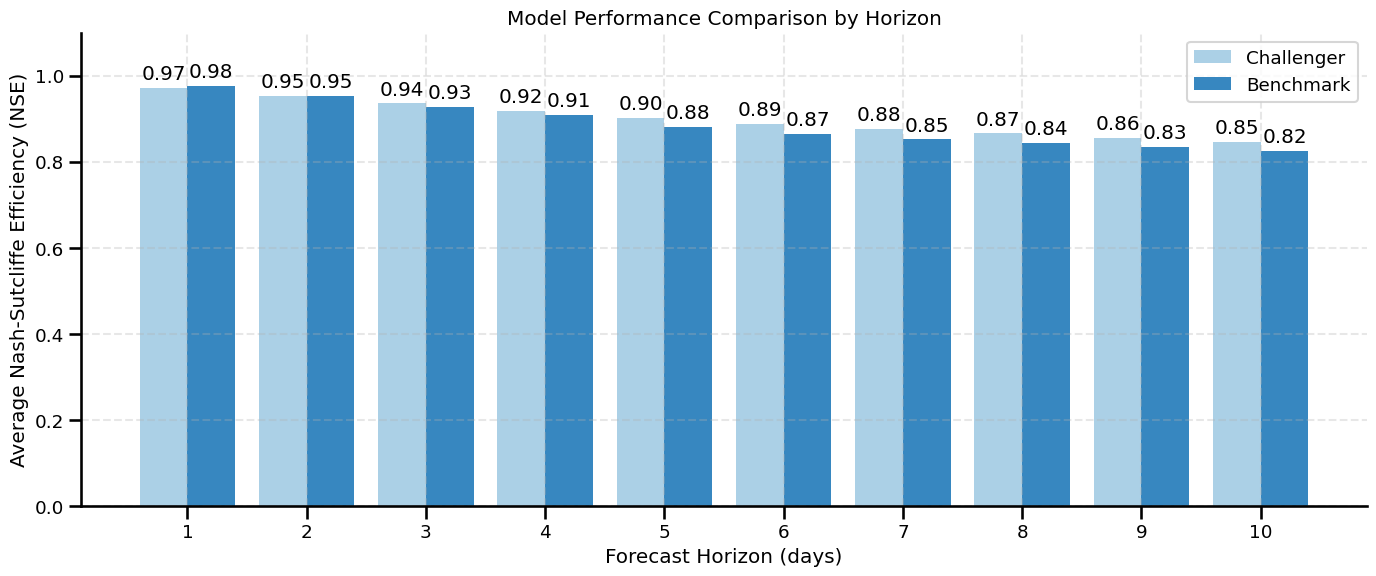

In [8]:
def plot_nse_comparison(challenger_df, benchmark_df):
    # Calculate mean NSE per horizon for both models
    challenger_avg = challenger_df.groupby("horizon")["NSE"].mean().reset_index()
    benchmark_avg = benchmark_df.groupby("horizon")["NSE"].mean().reset_index()

    palette = sns.color_palette("Blues", n_colors=2)

    # Merge data
    comparison = pd.merge(
        challenger_avg,
        benchmark_avg,
        on="horizon",
        suffixes=("_challenger", "_benchmark"),
    )
    # Plot styling
    plt.figure(figsize=(14, 6))
    bar_width = 0.4
    x_pos = np.arange(len(comparison))

    # Create bars
    plt.bar(
        x_pos - bar_width / 2,
        comparison["NSE_challenger"],
        width=bar_width,
        label="Challenger",
        color=palette[0],
    )

    plt.bar(
        x_pos + bar_width / 2,
        comparison["NSE_benchmark"],
        width=bar_width,
        label="Benchmark",
        color=palette[1],
    )

    # Customize plot
    plt.xticks(x_pos, comparison["horizon"])
    plt.xlabel("Forecast Horizon (days)")
    plt.ylabel("Average Nash-Sutcliffe Efficiency (NSE)")
    plt.title("Model Performance Comparison by Horizon")
    plt.legend()
    plt.grid(True, alpha=0.3, linestyle="--")
    sns.despine()

    # Add value labels
    for i, (ch, bm) in enumerate(
        zip(comparison["NSE_challenger"], comparison["NSE_benchmark"])
    ):
        plt.text(i - bar_width / 2, ch + 0.02, f"{ch:.2f}", ha="center")
        plt.text(i + bar_width / 2, bm + 0.02, f"{bm:.2f}", ha="center")

    plt.ylim(top=1.1)  # NSE can theoretically exceed 1
    plt.tight_layout()
    plt.show()


overall_challenger = pd.read_csv(
    "/Users/cooper/Desktop/CAMELS-CH/experiments/Exp3/results/challenger_overall_metrics.csv"
)
overall_benchmark = pd.read_csv(
    "/Users/cooper/Desktop/CAMELS-CH/experiments/Exp3/results/overall_metrics.csv"
)

# Plot the comparison
plot_nse_comparison(overall_challenger, overall_benchmark)